# Looking at data

In [32]:
import os
import io
import random
from pathlib import Path
from PIL import Image
# import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
# import SimpleITK as sitk

In [33]:
from lunglens.data import *

In [34]:
data_dir = Path('../data/extracted')

## 2019nCoVR dataset

In [6]:
ds_dir = data_dir/'2019nCoVR'

In [7]:
all_files = list(ds_dir.glob('*CP/**/*.png'))
len(all_files)

276036

In [8]:
random_set = random.sample(all_files, 1000)

In [12]:
random_img = random.choice(all_files)

In [13]:
# load the image
image = Image.open(random_img)

# convert image to numpy array
data = np.asarray(image)

data.min(), data.mean(), data.max()

(37, 113.07988357543945, 255)

#### Looking at one random image

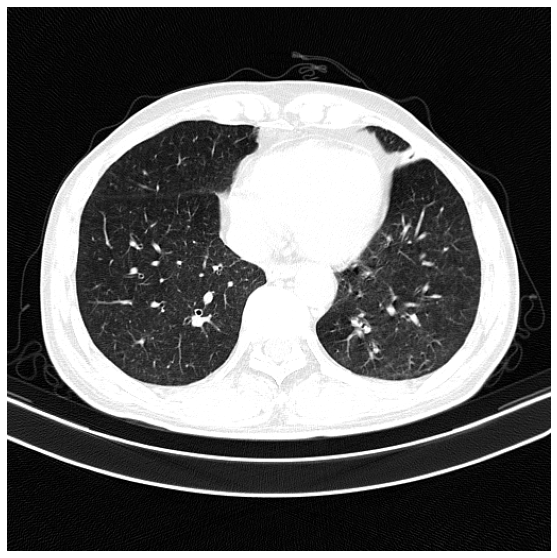

In [15]:
print_slice(data)

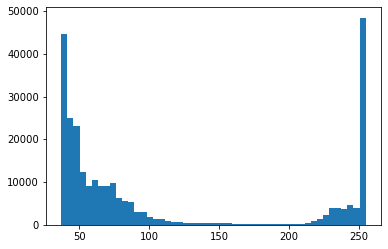

In [16]:
print_hist(data)

#### Looking at random subset

In [17]:
# convert image to numpy array
arrays = [np.asarray(Image.open(f)) for f in random_set]

In [18]:
from collections import Counter

shapes = [a.shape for a in arrays]
Counter(shapes)

Counter({(512, 512): 1000})

#### Discarding images with other shapes

In [20]:
data = np.stack([a for a in arrays if a.shape == (512, 512)])
data.shape

(1000, 512, 512)

In [21]:
data.min(), data.mean(), data.max()

(0, 124.87614274978638, 255)

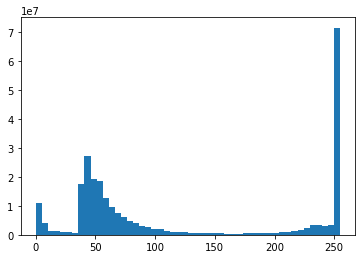

In [22]:
print_hist(data)

#### Looking at items with min_val close to 0

In [23]:
tmp_arrays = [a for a in arrays if a.shape == (512, 512) and a.min() < 10]
len(tmp_arrays)

189

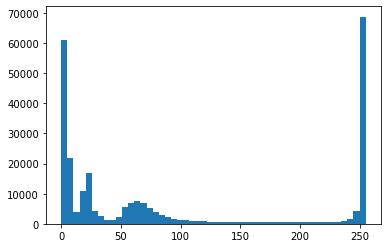

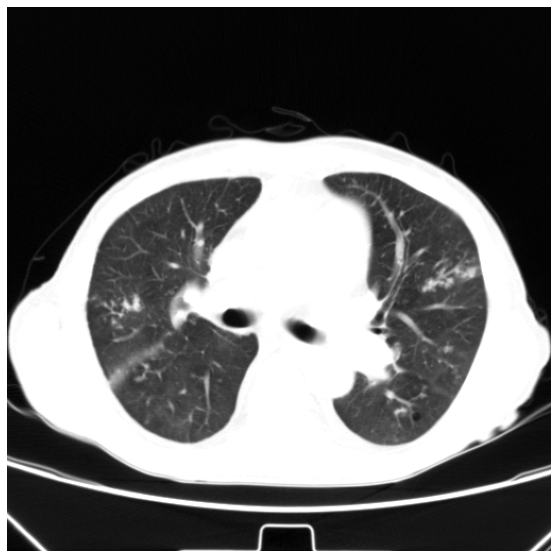

In [25]:
tmp_data = tmp_arrays[10]
print_hist(tmp_data)
print_slice(tmp_data)

#### We can see that window has been applied to the original DICOM images, but values squeezed to 0-250 range and moved

In [26]:
rescaled_data = (data - 255.0) * 5

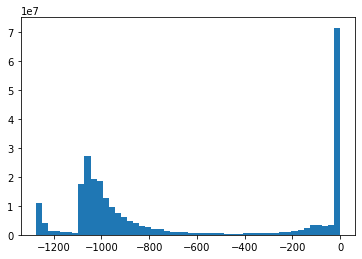

In [29]:
print_hist(rescaled_data)

### This looks similar to lung windowed CT image, but not exact. Looks like the top limit is a bit lower than the default one. We can try adding this dataset later

## COVID19_1110 dataset

In [35]:
ds_dir = data_dir/'COVID19_1110'

all_files = list(ds_dir.rglob('*.nii'))

len(all_files)

1110

In [36]:
random_set = random.sample(all_files, 10)

In [37]:
random_img = random.choice(all_files)

In [38]:
# Read the .nii image containing the volume with SimpleITK as numpy array:
data, _ = read_dicom_file(random_img)

data.min(), data.mean(), data.max()

(-2048, -703.6284500925165, 1788)

In [39]:
data.shape

(38, 512, 512)

#### Looking at one random image

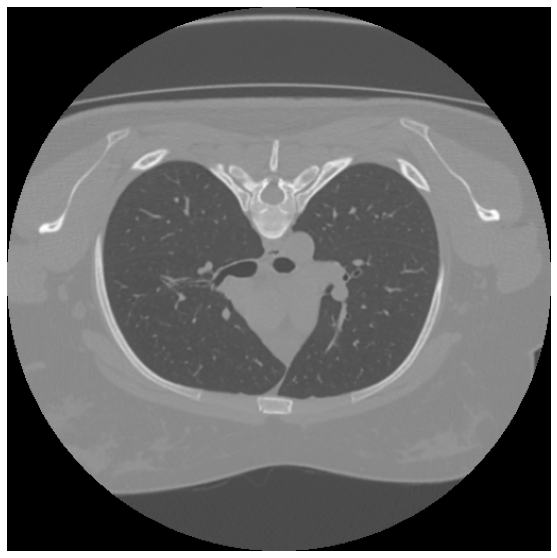

In [40]:
print_slice(data[25])

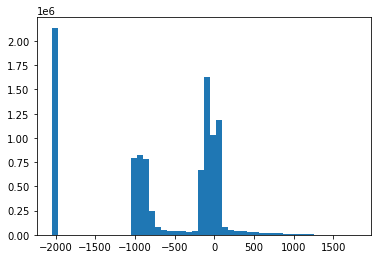

In [41]:
print_hist(data)

#### We can see that this image have no CT window applied

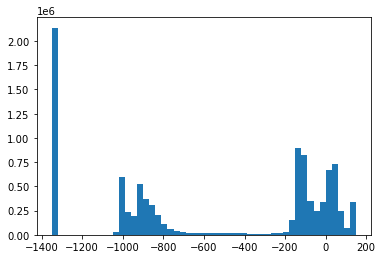

In [42]:
# windowed data
w_data = appply_window(data)
print_hist(w_data)

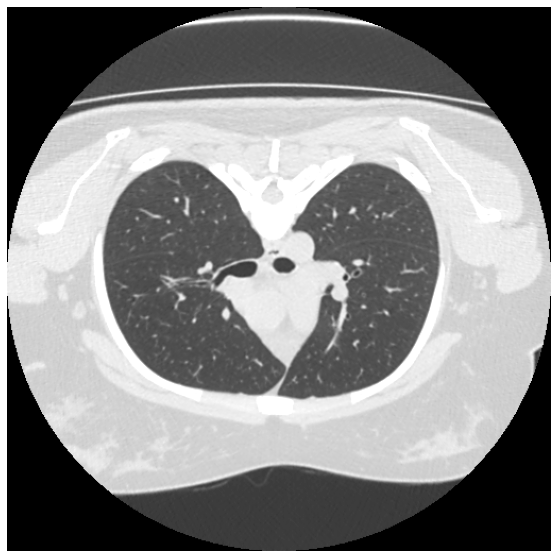

In [43]:
print_slice(w_data[25])

### Normal DICOM data. We can apply the conventional lung window and save as numpy

## COVID-CTset 

In [247]:
ds_dir = data_dir/'COVID-CTset'

In [248]:
all_files = list(ds_dir.rglob('*.tif'))

In [249]:
len(all_files)

63849

In [250]:
random_set = random.sample(all_files, 1000)

In [251]:
random_img = random.choice(all_files)

In [252]:
def read_covid_ctset_img(img_path):
    with open(img_path, 'rb') as f:
        tif = Image.open(io.BytesIO(f.read()))

    return np.array(tif)

In [253]:
# load the image
data = read_covid_ctset_img(random_img)

data.min(), data.mean(), data.max()

(0, 431.6964530944824, 2556)

#### Looking at one random image

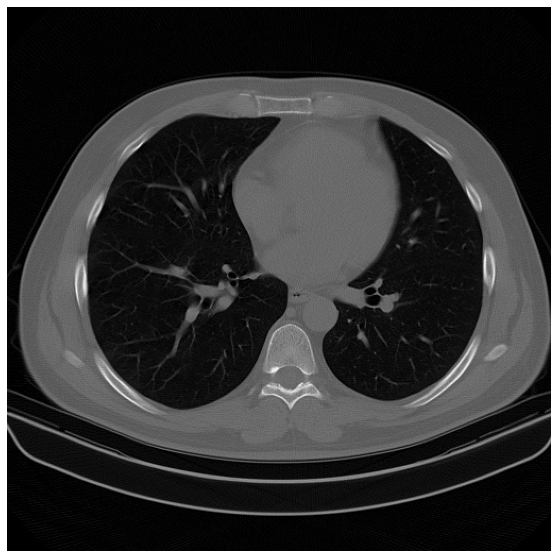

In [254]:
plt.figure(figsize = (10, 10))
plt.imshow(data, cmap='gray')
plt.axis('off');

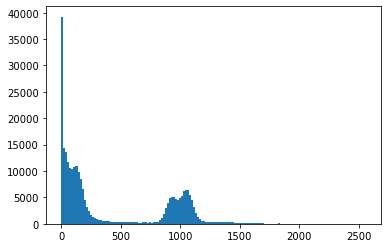

In [255]:
plt.hist(data.flatten(), bins=150);

#### Looking at random subset

In [256]:
# convert image to numpy array
arrays = [read_covid_ctset_img(f) for f in random_set]

In [260]:
data = np.stack(arrays)
data.shape

(1000, 512, 512)

In [261]:
data.min(), data.mean(), data.max()

(0, 489.66296585464477, 4095)

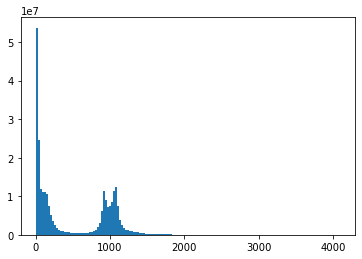

In [262]:
plt.hist(data.flatten(), bins=150);

#### This data looks weird

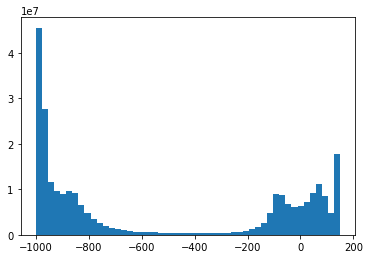

In [264]:
# windowed and moved data
w_data = appply_window(data - 1000.0)
plt.hist(w_data.flatten(), bins=50);

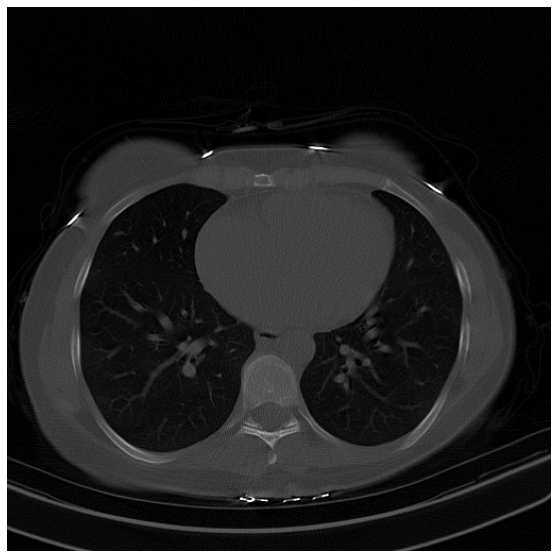

In [269]:
plt.figure(figsize = (10, 10))
plt.imshow(data[3], cmap='gray')
plt.axis('off');

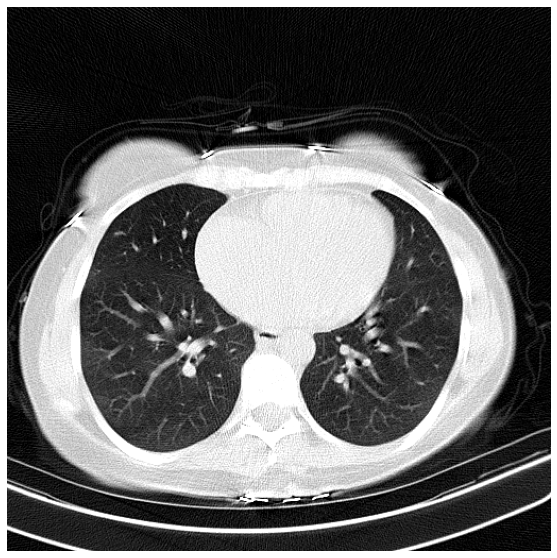

In [270]:
plt.figure(figsize = (10, 10))
plt.imshow(w_data[3], cmap='gray')
plt.axis('off');

#### Maybe this is the right rescaling but I am not sure. We can try it out later

## Kaggle: OSIC Pulmonary Fibrosis Progression

In [44]:
ds_dir = data_dir/'osic-pulmonary-fibrosis-progression'

In [45]:
all_files = list(ds_dir.rglob('ID0*'))

In [46]:
len(all_files)

181

In [47]:
random_set = random.sample(all_files, 10)

In [48]:
random_img = random.choice(all_files)
random_img

WindowsPath('../data/extracted/osic-pulmonary-fibrosis-progression/train/ID00273637202271319294586')

In [50]:
data, _ = read_dicom_folder(random_img)

data.min(), data.mean(), data.max()

(-1024, -531.7054130451099, 2034)

In [51]:
data.shape

(74, 512, 512)

#### Looking at one random image

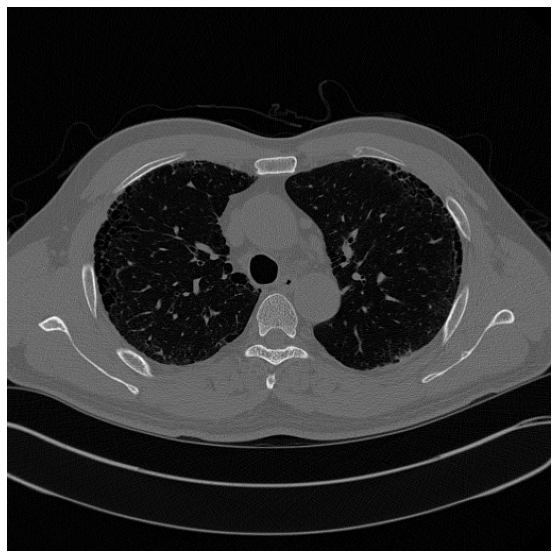

In [52]:
print_slice(data[50])

#### We can see that this image have no CT window applied

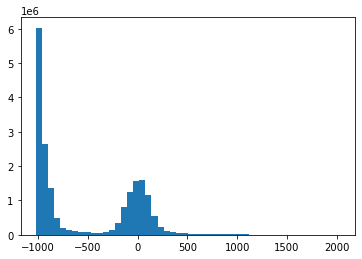

In [53]:
print_hist(data)

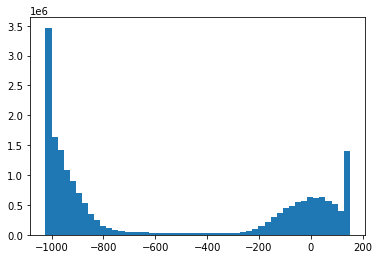

In [54]:
# windowed data
w_data = appply_window(data)
print_hist(w_data)

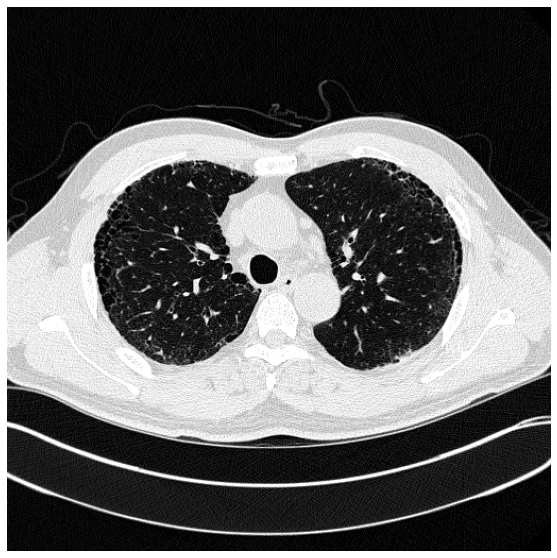

In [55]:
print_slice(w_data[50])